In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy.cluster.hierarchy import fcluster
import itertools
import scipy.stats as st
from tqdm import tqdm
from tslearn.metrics import dtw
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random
import pickle

# rimuovo alcuni warn che disturbano l'output dei risultati


def warn(*args, **kwargs):
    pass


warnings.warn = warn

C:\Users\danie\AppData\Local\pypoetry\Cache\virtualenvs\industry-lab-JWw7CphW-py3.9\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


 # DEFINIZIONE FUNZIONI

In [2]:
# DBSCAN
def dbscan_for_daily(spotname, ds, eps, min_samples):
    # utilizzo scaler allenato nella fase 02_Training, uno per spotname
    X = dict_scaler_dbscan_daily[spotname].transform(
        ds.loc[ds.spotName == spotname, 0:613])
    # train e test parametri
    predictions = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
    # assegno il risultato dell'algortimo al database
    ds.loc[ds.spotName == spotname, 'dbscan_daily'] = predictions

# dato un dataframe e una colonna e una feature indicante l'indice del cluster di appartenenza della curva,
# rappresenta ogni cluster e i relativi spotname contenuti al suo interno


def plot_cluster(dataframe, cluster_column='k_means_dtw'):
    # ottengo lista indici dei cluster
    list_cluster = dataframe[cluster_column].unique()

    # genero plot pari al numero di cluster
    fig, axs = plt.subplots(1, len(list_cluster),
                            figsize=(15, 7), sharey=True)
    for i in list_cluster:
        axs[i].set(xlabel=f'CLUSTER {i}')

    fig.suptitle(
        f'{cluster_column} --- Cluster degli andamenti giornalieri di tutti gli spotname', fontsize=15)

    # in base all'indice del cluster, plot nello specifico grafico
    for name_spot, row in dataframe.iterrows():
        axs[row[cluster_column]].plot(dataframe.loc[name_spot]
                                      ['CurrentCurve'], label=name_spot)
        # axs[row[cluster_column]].legend()
    fig.show()


def plot_CI_TS(spotname, dataframe_CI, df_CI_anomalies, axs):
    axs.set_title(f"C.I SU MEDIA CURVA GLOBALE")
    axs.set(xlabel='Millisecondi')
    axs.plot(dataframe_CI['mean'], color='blue',
             alpha=0.8, label=f'Media globale spotname n: {spotname}')
    axs.fill_between(
        dataframe_CI.index, dataframe_CI['lw_bound'], dataframe_CI['up_bound'], alpha=1, color='green', label='Intervallo di confidenza')
    axs.scatter(df_CI_anomalies['anom_index'], df_CI_anomalies['anom_values'],
                s=0.5, color='red', label=f'Anomalia --- Totale: {df_CI_anomalies.shape[0]}')
    axs.legend()
    plt.show()


def test_predictions(TS_daily, spotname, index_cluster, cut_off_thres, plot=False):
    model_IF = list_IF_models[index_cluster]
    predictions = model_IF.predict(np.array(TS_daily).reshape(-1, 1))

    dataset_test = pd.DataFrame(
        {'data': TS_daily, 'is_anomaly': predictions},
        index=range(0, len(TS_daily))
    )
    # non considero i primi cut_off_thres punti come anomalie -> is_anomaly ha indice pari a 1
    dataset_test.iloc[:cut_off_thres, 1] = 1
    anomaly_points = dataset_test[dataset_test.is_anomaly == -1]

    if plot:
        fig, axs = plt.subplots(1, 2,
                                figsize=(15, 7), sharex=True, sharey=True)
        fig.suptitle(
            f"SPOTNAME {spotname} --- MISURAZIONE GIORNALIERA", fontsize=15)
        axs[0].set_title(
            f"SPOTNAME CLUSTER {index_cluster} --- IS. FOREST")
        axs[0].set(xlabel='Millisecondi', ylabel='CurrentCurve (AMPERE)')
        axs[0].plot(anomaly_points.index,
                    anomaly_points['data'], 'ro', zorder=99, alpha=0.8, markersize=2.5, label=f'Anomalia -- TOTALE: {anomaly_points.shape[0]}')
        axs[0].plot(dataset_test['data'], 'g', linewidth=3,
                    zorder=2, label=f'Misurazione giornaliera spotname {spotname}')
        axs[0].legend()
    # lista tuple indice - valore del punto anomalo
    l_CI_anomalies = []
    for index, row in dict_CI[spotname].iterrows():
        if TS_daily[index] > row['up_bound'] or TS_daily[index] < row['lw_bound']:
            l_CI_anomalies.append((index, TS_daily[index]))

    df_CI_anomalies = pd.DataFrame(l_CI_anomalies, columns=[
        'anom_index', 'anom_values'])
    # non considero anomali i primi cut_off_thres punti
    df_CI_anomalies = df_CI_anomalies.iloc[cut_off_thres:]

    if plot:
        plot_CI_TS(spotname, dict_CI[spotname], df_CI_anomalies, axs[1])
    # ritorno numero anomalie trovate da CI e da IF
    return df_CI_anomalies.shape[0], anomaly_points.shape[0]

# CARICAMENTO DATI UTILI PER SVOLGERE LE PREVISIONI

In [3]:
# apertura file
test_DS = pd.read_pickle('../data/inference/unseen_data.pkl')
test_DS.drop(columns=['VoltageCurve'], inplace=True)

with open('../models/CI_global.pickle', 'rb') as f:
    dict_CI = pickle.load(f)
with open('../models/IF_models_cluster.pickle', 'rb') as f:
    list_IF_models = pickle.load(f)
with open('../models/dtw_cluster.pickle', 'rb') as f:
    dtw_cluster = pickle.load(f)

# carico dizionario contenente uno scaler per ogni spotname
with open('../models/dbscan_daily_scaler.pickle', 'rb') as f:
    dict_scaler_dbscan_daily = pickle.load(f)

In [4]:
exploded_col_lists = test_DS['CurrentCurve'].apply(pd.Series)
expanded_TS = pd.concat([test_DS, exploded_col_lists],
                        axis=1)
expanded_TS.drop(columns='CurrentCurve', inplace=True)
# imputiamo i nan sostituendoli con la media delle misurazioni
expanded_TS.loc[:, 0:] = expanded_TS.loc[:, 0:].apply(
    lambda row: row.fillna(row.mean()), axis=1)

In [5]:
# settiamo con un valore costante la colonna che conterrà la previsione del dbscan
expanded_TS['dbscan_daily'] = 2
# svolgiamo le previsioni per ogni CC giornaliera di ogni spotname
for spotname in tqdm(expanded_TS.spotName.unique(), total=len(expanded_TS.spotName.unique())):
    dbscan_for_daily(spotname, expanded_TS, 30, 20)

# assegno previsioni DBSCAN al dataset che conterrà tutte le previsioni di tutti i modelli
test_DS['dbscan_daily'] = expanded_TS['dbscan_daily']

100%|██████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 190.63it/s]


In [6]:
expanded_TS.set_index('spotName', inplace=True)

# Applicazione dei modelli su una singola misurazione

In [7]:
# minimo numero di punti necesarri per classificare una curva come anomala o meno
ANOM_THRESHOLD_CI = 150
ANOM_THRESHOLD_IF = 50

# se True viene dato in output il grafico su cui sono segnati i punti anomali della curva
plot = True

# numero di punti anomali INIZIALI da non considerare
cut_off_thres = 10

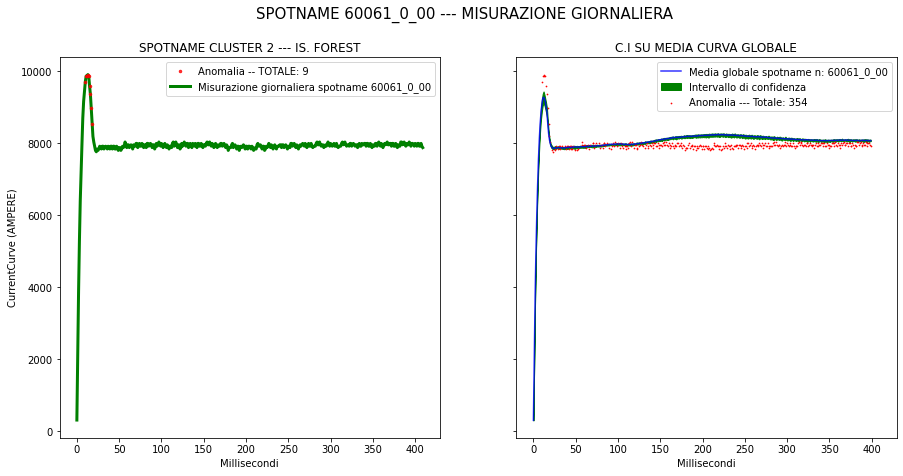

In [8]:
# lettura JSON

with open("../data/original/json_test.json", 'r') as f:
    data = json.load(f)

# estraggo identificatore spotname da JSON
n_spotname = data['Message']['WeldLog']['spotName']

# estraggo CC da JSON
CC = data['Message']['WeldLog']['CurrentCurve']

############ ISOLATION FOREST AND CONFIDENCE INTERVAL ############

# calcoliamo indice del cluster in modo da utilizzare il rispettivo modello k-means
cluster_index = dtw_cluster.predict(np.array(CC).reshape(1, -1))[0]
# visualizzazione grafica delle anomalie in base al modello utilizzato (IF e CI)
n_anom_IF, n_anom_CI = test_predictions(
    CC, n_spotname, cluster_index, cut_off_thres, plot)

############ DBSCAN ############

CC = np.pad(CC, (0, 613 - (len(CC)) + 1), mode='mean')
dataset_test = expanded_TS.loc[n_spotname, 0:613]
# inserisco cc da testare come ultima riga del dataset contenente le CC di quello spotname
dataset_test = dataset_test.append(pd.Series(CC), ignore_index=True)
X = dict_scaler_dbscan_daily[n_spotname].transform(dataset_test)
# considero solo la previsione relativa all'ultima riga, ovvero la CC che abbiamo inserito in coda al DS
pred_DBSCAN = DBSCAN(eps=30, min_samples=20).fit_predict(X)[-1]

In [9]:
# COSA DICONO I NOSTRI MODELLI?
n_mod_agree = 0
if n_anom_IF >= ANOM_THRESHOLD_IF:
    n_mod_agree += 1
if n_anom_CI >= ANOM_THRESHOLD_CI:
    n_mod_agree += 1
if pred_DBSCAN == -1:
    n_mod_agree += 1
print(f"{n_mod_agree} dei nostri modelli concordano nel dire che la curvatura data potrebbe presentare delle anomalie!")

2 dei nostri modelli concordano nel dire che la curvatura data potrebbe presentare delle anomalie!
